In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import os
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input, BatchNormalization, Multiply, ZeroPadding2D, Activation, Add, AveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.initializers import glorot_uniform

from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

In [2]:
arabic_characters = ['أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ','ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع','غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ى']

arabic_characters.sort()

arabic_characters = np.array(arabic_characters)

arabic_characters

array(['أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش',
       'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه',
       'و', 'ى'], dtype='<U1')

In [3]:
datapath = "../input/arabic-hwr-ai-pro-intake1"
train_df = pd.read_csv(os.path.join(datapath,"train.csv"))
test_df  = pd.read_csv(os.path.join(datapath,"test.csv"))

train_df

,id,label
0,0,24
1,1,2
2,2,17
3,3,14
4,4,19
...,...,...
13435,13435,5
13436,13436,26
13437,13437,2
13438,13438,24


---
# Curate Dataset
---

In [4]:
if not os.path.isdir(os.path.join('/kaggle/working/train_labeled/')):
    os.mkdir('/kaggle/working/train_labeled/')

for _, row in train_df.iterrows():
    f = row['id']
    l = row['label']
    
    if not os.path.isdir(os.path.join( './train_labeled/{}/'.format(arabic_characters[l-1]))):
        os.mkdir(os.path.join('./train_labeled/{}/'.format(arabic_characters[l-1])))
        
    shutil.copy('../input/arabic-hwr-ai-pro-intake1/train/{:05d}.png'.format(f), './train_labeled/{}/'.format(arabic_characters[l-1]))

---
# Create Generator
---

In [5]:
BATCH_SIZE = 32

### Create Train Generator
datagen = ImageDataGenerator( 
            zca_whitening=True,         # apply ZCA whitening
            zoom_range = 0.1,           # Randomly zoom image 
            width_shift_range=0.1,      # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,     # randomly shift images vertically (fraction of total height)
            validation_split=0.2 
            # featurewise_center=False, # set input mean to 0 over the dataset
            # samplewise_center=False,  # set each sample mean to 0
            # featurewise_std_normalization=False,  # divide inputs by std of the dataset
            # samplewise_std_normalization=False,   # divide each input by its std
            # rotation_range=10,        # randomly rotate images in the range (degrees, 0 to 180)
            # horizontal_flip=False,    # randomly flip images
            # vertical_flip=False,      # randomly fli
)

datagen

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [6]:
train_dir = '/kaggle/working/train_labeled/'

### Create Train Generator
train_gen = datagen.flow_from_directory(train_dir,
                                       batch_size=BATCH_SIZE,
                                       target_size=(32, 32),
                                       subset='training',
#                                        shuffle=False,
#                                        color_mode='grayscale',
                                       )

Found 10752 images belonging to 28 classes.


In [7]:
### Set as Validation data
val_gen = datagen.flow_from_directory( train_dir,     # same directory as training data                                    
                                       batch_size=BATCH_SIZE,
                                       target_size=(32, 32),
                                       subset='validation' ,
) 

Found 2688 images belonging to 28 classes.


In [8]:
# train_gen has 168 tuples of Batches ( Batch_size= 64 Images)
len(train_gen)

336

In [9]:
len(train_gen[0])

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


2

['أ/02684.png', 'أ/02687.png', 'أ/02709.png', 'أ/02845.png', 'أ/02878.png', 'أ/02894.png', 'أ/02936.png', 'أ/02952.png', 'أ/02980.png', 'أ/03013.png', 'أ/03046.png', 'أ/03056.png', 'أ/03069.png', 'أ/03173.png', 'أ/03192.png', 'أ/03231.png', 'أ/03328.png', 'أ/03369.png', 'أ/03440.png', 'أ/03486.png', 'أ/03490.png', 'أ/03516.png', 'أ/03517.png', 'أ/03578.png', 'أ/03650.png', 'أ/03735.png', 'أ/03742.png', 'أ/03771.png', 'أ/03800.png', 'أ/03877.png', 'أ/03891.png', 'أ/03934.png']


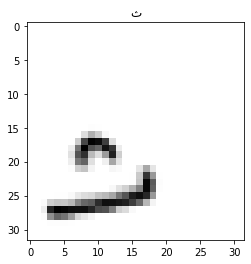

In [10]:
for i in train_gen:
    plt.imshow(i[0][1][:,:,1],'binary')
    plt.title(arabic_characters[np.argmax (i[1][1])])
    idx = (train_gen.batch_index - 1) * train_gen.batch_size
    print(train_gen.filenames[idx : idx + train_gen.batch_size])
    break

In [11]:
# each batch has 2 items    [in case BATCH_SIZE=64]
#   1--> Image (32 x 32x 3)    , 64 Images  --> 64 x 32 x 32 x 3
print( train_gen[0][0].shape )

#   2--> Label as a sparse-matrix (1 x 28 )   , 64 Images  --> 64 x 28
print( train_gen[0][1].shape )

(32, 32, 32, 3)
(32, 28)


In [12]:
print(train_gen[0][0][1].shape)

(32, 32, 3)


In [13]:
# train_gen.filenames
# datagen.flow_from_directory?
# class_mode=None

In [14]:
### TEST TTTTTTTTTTTTTTTTTTTTTTTTT  

### Create TEST Generator
test_dir = '../input/arabic-hwr-ai-pro-intake1/test'

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(32, 32),
    batch_size=30,
    shuffle=False,
    label_mode=None,
    # seed=123,
)

file_names = [ int( img.split('/')[-1].split('.')[0]) for img in test_ds.file_paths ]

file_names[:20]

Found 3360 files belonging to 1 classes.


2021-11-07 01:27:11.242739: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 01:27:11.336743: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 01:27:11.337422: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 01:27:11.340095: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [15]:
## Explaining --> each take is a batch of 64 images
list(test_ds.take(1))[0].shape

2021-11-07 01:27:13.882208: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


TensorShape([30, 32, 32, 3])

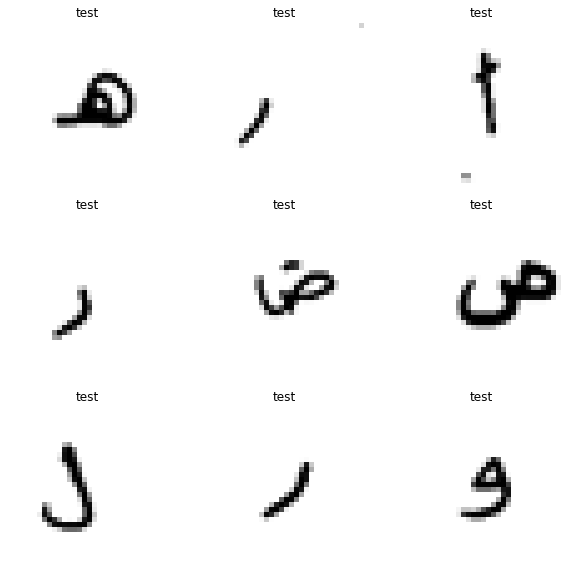

In [16]:
#### Test Plotting
plt.figure(figsize=(10, 10))

for images in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i][:,:,1].numpy().astype("uint8"),'binary')
        plt.title('test')
        plt.axis("off")

In [17]:
list(test_ds.take(1))[0][0].shape

TensorShape([32, 32, 3])

----
# MODELS WITH DIFFERENT ARCHITECTURE
----

## `01`- CNN

In [18]:
def get_CNN_model():
    In = Input(shape=(32,32,3))
    
    x = Conv2D(32, (5,5), padding="same", activation="relu")(In)
    x = Conv2D(32, (5,5), padding="same", activation="relu")(x)
    x = Conv2D(32, (5,5), padding="same", activation="relu")(x)
    x = MaxPooling2D((2,2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(64, (3,3), padding="same", activation="relu")(x)
    x = Conv2D(64, (3,3), padding="same", activation="relu")(x)
    x = Conv2D(64, (3,3), padding="same", activation="relu")(x)
    x = MaxPooling2D((2,2))(x)  # try  MaxPooling2D((2,2),strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    
    x = Flatten()(x)
    x = Dense(256, activation="relu")(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.4)(x)
    
    Out = Dense(28, activation="softmax")(x)
    
    model = Model(In, Out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model

In [19]:
model_01 = get_CNN_model()
model_01.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        25632     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0     

In [20]:
# create checkpoint to save model after every epoch
checkpoint_cb = ModelCheckpoint(filepath='model_01.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

# create early stopping checkpoint
early_stopping_cb = EarlyStopping(patience=100, restore_best_weights=True)


history_01 = model_01.fit(train_gen,
                    epochs = 500,
                    steps_per_epoch  = train_gen.samples // BATCH_SIZE,
                    validation_data  = val_gen,
                    validation_steps = val_gen.samples // BATCH_SIZE,
                    callbacks        = [checkpoint_cb, early_stopping_cb] )

model_01 = load_model('../working/model_01.h5')

Epoch 1/500


2021-11-07 01:27:17.118862: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


336/336 [==============================] - 18s 33ms/step - loss: 2.7233 - accuracy: 0.1861 - val_loss: 1.9081 - val_accuracy: 0.3605

Epoch 00001: val_accuracy improved from -inf to 0.36049, saving model to model_01.h5
Epoch 2/500
336/336 [==============================] - 11s 32ms/step - loss: 1.5938 - accuracy: 0.4557 - val_loss: 1.4819 - val_accuracy: 0.4996

Epoch 00002: val_accuracy improved from 0.36049 to 0.49963, saving model to model_01.h5
Epoch 3/500
336/336 [==============================] - 11s 34ms/step - loss: 1.0258 - accuracy: 0.6508 - val_loss: 1.5838 - val_accuracy: 0.4699

Epoch 00003: val_accuracy did not improve from 0.49963
Epoch 4/500
336/336 [==============================] - 11s 32ms/step - loss: 0.7134 - accuracy: 0.7644 - val_loss: 2.0069 - val_accuracy: 0.4152

Epoch 00004: val_accuracy did not improve from 0.49963
Epoch 5/500
336/336 [==============================] - 12s 35ms/step - loss: 0.5652 - accuracy: 0.8183 - val_loss: 0.4824 - val_accuracy: 0.8467


In [21]:
# model_01 = load_model('../input/messi-pretrained-model/model_1_CNN_ALI.h5')
# # model_01.summary()

In [22]:
model_01.evaluate(train_gen)
model_01.evaluate(val_gen) 

84/84 [==============================] - 2s 27ms/step - loss: 0.1157 - accuracy: 0.9818


[0.11572624742984772, 0.9817708134651184]

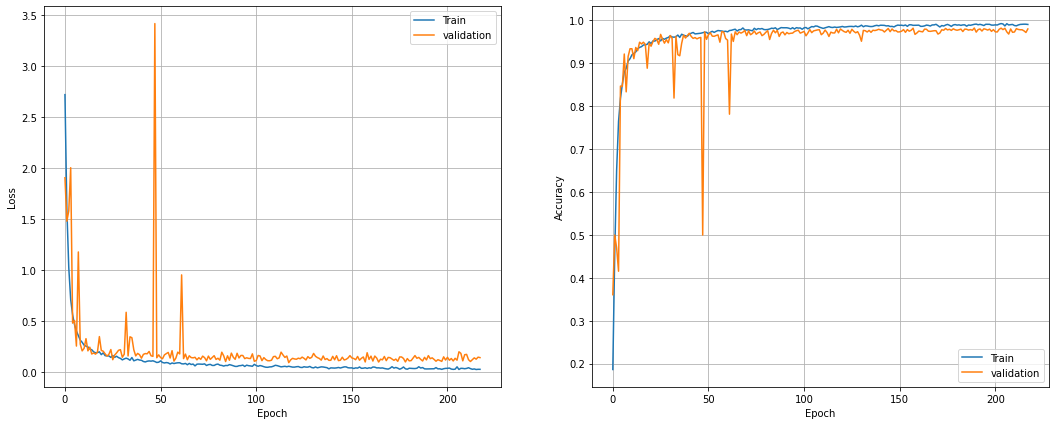

In [23]:
hist = pd.DataFrame(history_01.history)

fig, ax = plt.subplots(1,2, figsize=(18,7))
ax[0].plot(hist.loss, label='Train' )
ax[0].plot(hist.val_loss, label='validation' )
ax[0].legend()
ax[0].grid()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')


ax[1].plot(hist.accuracy, label='Train' )
ax[1].plot(hist.val_accuracy, label='validation' )
ax[1].legend()
ax[1].grid()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
plt.show()


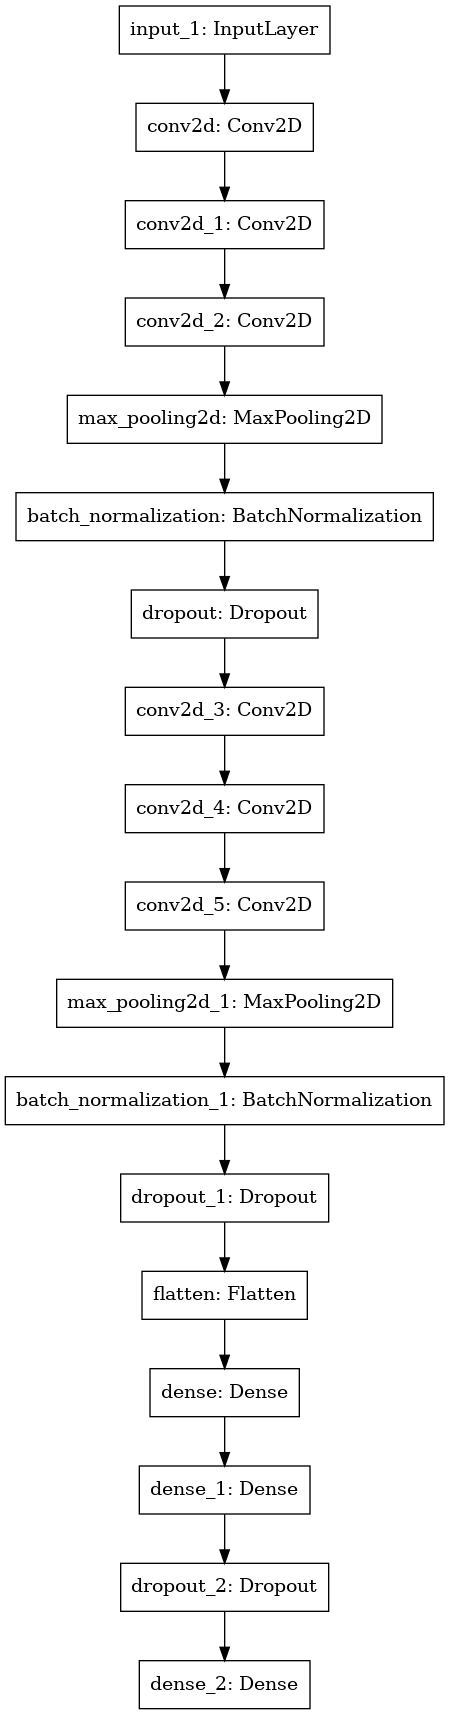

In [24]:
keras.utils.plot_model(model_01)

----
## `02`- Transfer/VGG16

In [25]:
def get_VGG16_model():
    
    base_model = tf.keras.applications.VGG16(weights = 'imagenet', include_top = False, input_shape = (32,32,3))
    
    for layer in base_model.layers:
          layer.trainable = True
  

    x = Flatten()(base_model.output)
    x = BatchNormalization()(x)
    x = Dense(256, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation="relu")(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    
    Out = Dense(28, activation="softmax")(x)
    
    model = Model(inputs = base_model.input, outputs = Out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model

In [26]:
#### OLD
# def get_VGG16_model():
    
#     base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(32,32,3))
    
#     for layer in base_model.layers:
#           layer.trainable = True


#     x = Flatten()(base_model.output)
#     x = BatchNormalization()(x)
#     x = Dense(256, activation="relu")(x)

#     x = BatchNormalization()(x)
#     x = Dense(128, activation="relu")(x)
    
#     x = Dense(128, activation="relu")(x)
#     x = Dropout(0.5)(x)
    
#     Out = Dense(28, activation="softmax")(x)
    
#     model = Model(inputs = base_model.input, outputs = Out)
#     model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
#     return model

In [27]:
model_02 = get_VGG16_model()
model_02.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
____________________________________________________________

In [28]:
# create checkpoint to save model after every epoch
checkpoint_cb = ModelCheckpoint(filepath='model_02.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

# create early stopping checkpoint
early_stopping_cb = EarlyStopping(patience=100, restore_best_weights=True)


history_02 = model_02.fit(train_gen,
                        epochs = 500,
                        steps_per_epoch  = train_gen.samples // BATCH_SIZE,
                        validation_data  = val_gen,
                        validation_steps = val_gen.samples // BATCH_SIZE,
                        callbacks        = [checkpoint_cb, early_stopping_cb] )

model_02 = load_model('../working/model_02.h5')

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/500
336/336 [==============================] - 14s 38ms/step - loss: 2.9329 - accuracy: 0.0972 - val_loss: 4.6911 - val_accuracy: 0.0722

Epoch 00001: val_accuracy improved from -inf to 0.07217, saving model to model_02.h5
Epoch 2/500
336/336 [==============================] - 12s 37ms/step - loss: 2.3674 - accuracy: 0.1722 - val_loss: 2.8997 - val_accuracy: 0.1124

Epoch 00002: val_accuracy improved from 0.07217 to 0.11235, saving model to model_02.h5
Epoch 3/500
336/336 [==============================] - 14s 41ms/step - loss: 1.9322 - accuracy: 0.2787 - val_loss: 2.0548 - val_accuracy: 0.2258

Epoch 00003: val_accuracy improved from 0.11235 to 0.22582, saving model to model_02.h5
Epoch 4/500
336/336 [==============================] - 13s 39ms/step - loss: 1.6227 - accuracy: 0.4015 - val_loss: 3.4474 - val_accuracy: 0.1112

Epoch 00004: val_accuracy did not improve from 0.22582
Epoch 5/500
336/336 [==============================] - 13s 39ms/step - loss: 1.4628 - accuracy: 0.45

In [29]:
# # model_02 = load_model('../input/messi-pretrained-model/Nabil_vgg16.h5') 
# model_02 = load_model('../input/messi-pretrained-model/VGG16_updated.h5') 
# # model_02.summary()

In [30]:
model_02.evaluate(train_gen) 
model_02.evaluate(val_gen) 

84/84 [==============================] - 2s 27ms/step - loss: 0.1125 - accuracy: 0.9821


[0.11251775175333023, 0.9821428656578064]

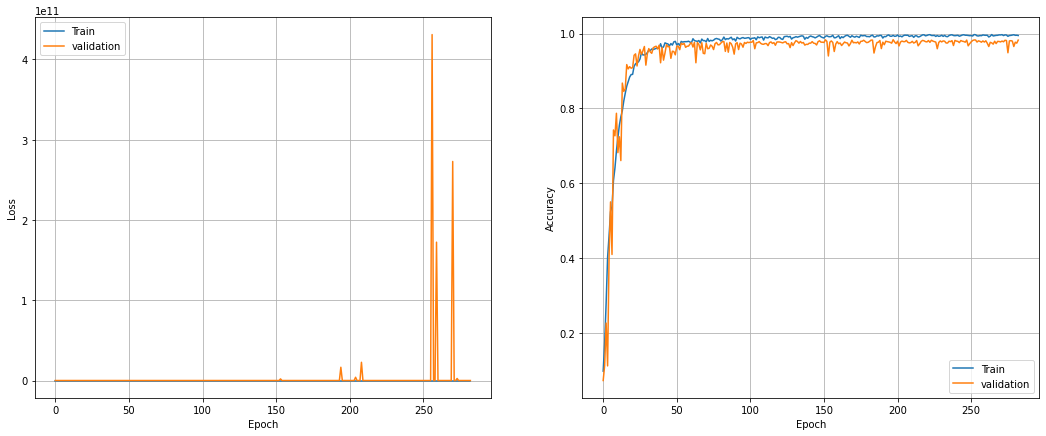

In [31]:
hist = pd.DataFrame(history_02.history)

fig, ax = plt.subplots(1,2, figsize=(18,7))
ax[0].plot(hist.loss, label='Train' )
ax[0].plot(hist.val_loss, label='validation' )
ax[0].legend()
ax[0].grid()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')


ax[1].plot(hist.accuracy, label='Train' )
ax[1].plot(hist.val_accuracy, label='validation' )
ax[1].legend()
ax[1].grid()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
plt.show()


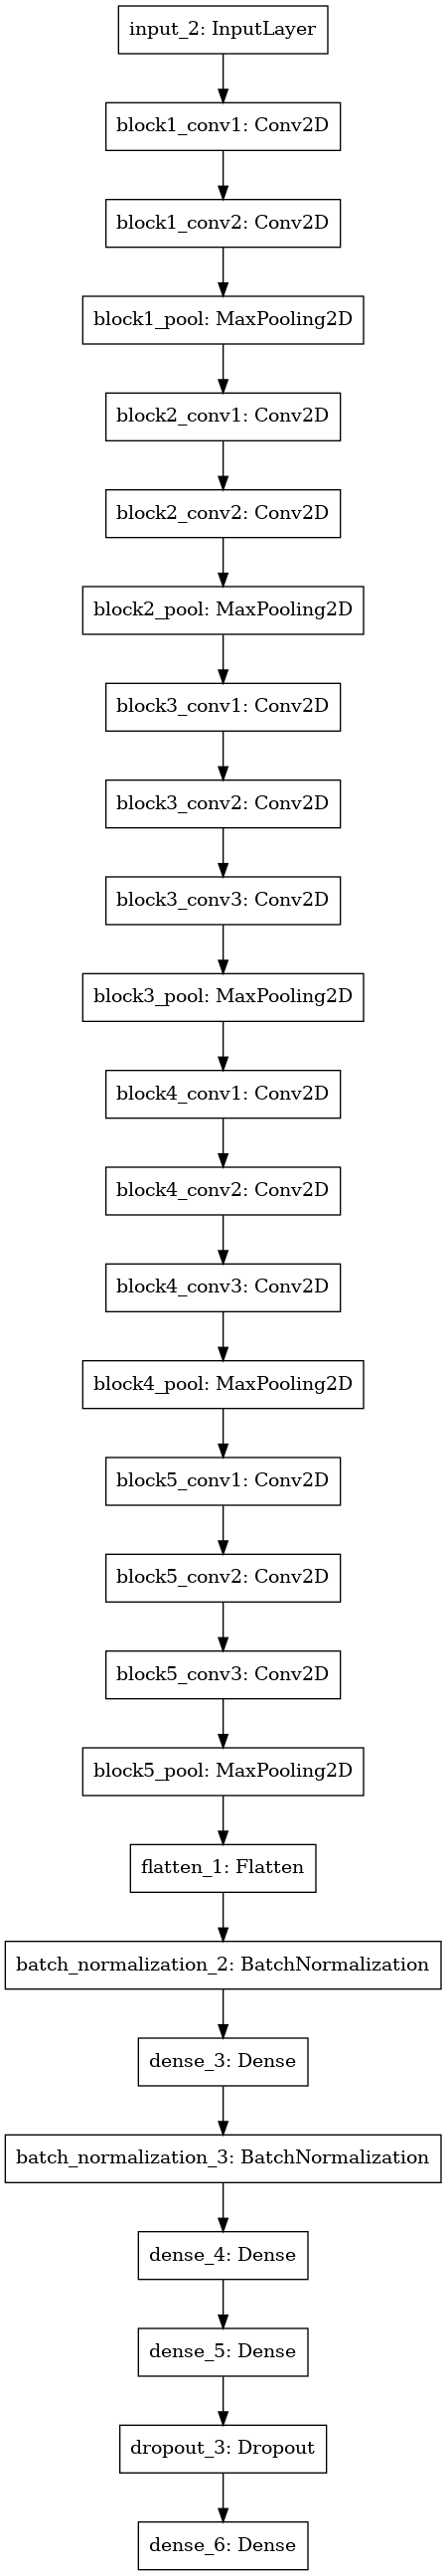

In [32]:
keras.utils.plot_model(model_02)

----
## `03`- Transfer/MOBILENET

In [33]:
def get_MobileNetV2_Trimmed_model():
    base_model = keras.applications.MobileNet(weights='imagenet',include_top=False)    #imports the mobilenet model and discards the last 1000 neuron layer.

    original_dim = (32, 32, 3)
    target_size  = (75, 75)
    input_layer  = keras.layers.Input(original_dim)
    base_model.layers[0] = tf.keras.layers.Lambda(lambda image: tf.image.resize(image, target_size))(input_layer)
    
    x = base_model.output
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = Dense(1024,activation='relu')(x)     # we add dense layers so that the model can learn more complex functions and classify for better results.
    x = Dense(1024,activation='relu')(x)     # dense layer 2
    x = Dense(512,activation='relu')(x)      # dense layer 3
    preds = Dense(28,activation='softmax')(x) # final layer with softmax activation


    model = keras.models.Model(inputs=base_model.input, outputs=preds)
    model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adamax(lr=0.001, decay=1e-4,beta_1=0.9,beta_2=0.999), metrics=["accuracy"])
    
    return model

In [34]:
# model_03 = get_MobileNetV2_Trimmed_model()
# model_03.summary()

In [35]:
# # create checkpoint to save model after every epoch
# checkpoint_cb = ModelCheckpoint(filepath='model_03.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

# # create early stopping checkpoint
# early_stopping_cb = EarlyStopping(patience=50, restore_best_weights=True)


# history_03 = model_03.fit(train_gen,
#                     epochs = 500,
#                     steps_per_epoch  = train_gen.samples // BATCH_SIZE,
#                     validation_data  = val_gen,
#                     validation_steps = val_gen.samples // BATCH_SIZE,
#                     callbacks        = [checkpoint_cb, early_stopping_cb] )


# model_03 = load_model('../working/model_03.h5')

In [36]:
# model_03 = load_model('../input/messi-pretrained-model/model_4_MobNet_97.5_Messi.h5') 
# # model_03.summary()

In [37]:
# model_03.evaluate(train_gen) 
# model_03.evaluate(val_gen) 

In [38]:
# hist = pd.DataFrame(history_03.history)

# fig, ax = plt.subplots(1,2, figsize=(18,7))
# ax[0].plot(hist.loss, label='Train' )
# ax[0].plot(hist.val_loss, label='validation' )
# ax[0].legend()
# ax[0].grid()
# ax[0].set_xlabel('Epoch')
# ax[0].set_ylabel('Loss')


# ax[1].plot(hist.accuracy, label='Train' )
# ax[1].plot(hist.val_accuracy, label='validation' )
# ax[1].legend()
# ax[1].grid()
# ax[1].set_xlabel('Epoch')
# ax[1].set_ylabel('Accuracy')
# plt.show()

In [39]:
# keras.utils.plot_model(model_03)

----
## `04`- Transfer/Xception

In [40]:
# def get_xception_model():
    
#     base_model = tf.keras.applications.xception.Xception(weights='imagenet', include_top=False)
#     original_shape = (32,32,3)
#     target_size = (71, 71)
#     input_layer = keras.layers.Input(original_shape)
#     base_model.layers[0] = tf.keras.layers.Lambda(lambda image: tf.image.resize(image, target_size))(input_layer)
    
#     for layer in base_model.layers:
#           layer.trainable = True

#     x = base_model.output
#     x = keras.layers.GlobalAveragePooling2D()(x)
#     x = Dense(256, activation="relu")(x)
#     x = BatchNormalization()(x)
#     x = Dense(128, activation="relu")(x)
#     x = Dense(128, activation="relu")(x)
#     x = Dropout(0.5)(x)
    
#     Out = Dense(28, activation="softmax")(x)
    
#     model = Model(inputs = base_model.input, outputs = Out)
#     model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
#     return model

In [41]:
# model_04 = get_xception_model()
# model_04.summary()

In [42]:
# # create checkpoint to save model after every epoch
# checkpoint_cb = ModelCheckpoint(filepath='model_04.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

# # create early stopping checkpoint
# early_stopping_cb = EarlyStopping(patience=30, restore_best_weights=True)


# history_04 = model_04.fit(train_gen,
#                     epochs = 500,
#                     steps_per_epoch  = train_gen.samples // BATCH_SIZE,
#                     validation_data  = val_gen,
#                     validation_steps = val_gen.samples // BATCH_SIZE,
#                     callbacks        = [checkpoint_cb, early_stopping_cb] )

# model_04 = load_model('../working/model_04.h5')

In [43]:
# model_04 = load_model('../input/messi-pretrained-model/Xception_Afnan.h5')  
# # model_04.summary()

In [44]:
# model_04.evaluate(train_gen) 
# model_04.evaluate(val_gen) 

In [45]:
# hist = pd.DataFrame(history_04.history)

# fig, ax = plt.subplots(1,2, figsize=(18,7))
# ax[0].plot(hist.loss, label='Train' )
# ax[0].plot(hist.val_loss, label='validation' )
# ax[0].legend()
# ax[0].grid()
# ax[0].set_xlabel('Epoch')
# ax[0].set_ylabel('Loss')


# ax[1].plot(hist.accuracy, label='Train' )
# ax[1].plot(hist.val_accuracy, label='validation' )
# ax[1].legend()
# ax[1].grid()
# ax[1].set_xlabel('Epoch')
# ax[1].set_ylabel('Accuracy')
# plt.show()

In [46]:
# keras.utils.plot_model(model_04)

----
## `05`- Transfer + Merged (CNN + VGG16)

In [47]:
def get_merged_model():
    # First Model
    In_1 = Input(shape=(32,32,3))
    
    m_1 = Conv2D(32, (5,5), padding="same", activation="relu")(In_1)
    m_1 = Conv2D(32, (5,5), padding="same", activation="relu")(m_1)
    m_1 = Conv2D(32, (5,5), padding="same", activation="relu")(m_1)
    m_1 = MaxPooling2D((2,2))(m_1)
    m_1 = BatchNormalization()(m_1)
    m_1 = Dropout(0.25)(m_1)
    
    m_1 = Conv2D(64, (3,3), padding="same", activation="relu")(m_1)
    m_1 = Conv2D(64, (3,3), padding="same", activation="relu")(m_1)
    m_1 = Conv2D(64, (3,3), padding="same", activation="relu")(m_1)
    m_1 = MaxPooling2D((2,2))(m_1)  # try  MaxPooling2D((2,2),strides=(2, 2))(x)
    m_1 = BatchNormalization()(m_1)
    m_1 = Dropout(0.25)(m_1)
    
    m_1 = Flatten()(m_1)
    m_1 = BatchNormalization()(m_1)
    m_1 = Dense(256, activation="relu")(m_1)
    
    # Second Model
    base_model = tf.keras.applications.VGG16(weights = 'imagenet', include_top = False, input_shape = (32,32,3))
    
    for layer in base_model.layers:
          layer.trainable = True
  

    m_2 = Flatten()(base_model.output)
    m_2 = BatchNormalization()(m_2)
    m_2 = Dense(256, activation="relu")(m_2)

    
    x = Multiply()([m_1, m_2])
    x = Dense(256, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation="relu")(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    
    Out = Dense(28, activation="softmax")(x)
    
    model = Model(inputs = [In_1, base_model.input], outputs = Out)
    
    opt = tf.keras.optimizers.Adamax(lr=0.001, decay=1e-4,beta_1=0.9,beta_2=0.999)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    
    return model

In [48]:
def get_data(gen):
    while True:
        Xi = gen.next()
        yield [Xi[0], Xi[0]], Xi[1]
        
        
def get_evaluate_data(gen):
    for _ in range(len(gen)):
        Xi = gen.next()
        yield [Xi[0], Xi[0]], Xi[1]
        
        
def get_predict_data(gen):
    for _ in range(len(list(gen.as_numpy_iterator()))):
        Xi = gen.as_numpy_iterator().next()
        yield [Xi, Xi]

In [49]:
# model_05 = get_merged_model()
# model_05.summary()

In [50]:
# # create checkpoint to save model after every epoch
# checkpoint_cb = ModelCheckpoint(filepath='model_05.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

# # create early stopping checkpoint
# early_stopping_cb = EarlyStopping(patience=100, restore_best_weights=True)


# history_05 = model_05.fit(get_data(train_gen),
#                     epochs = 500,
#                     steps_per_epoch  = train_gen.samples // BATCH_SIZE,
#                     validation_data  = get_data(val_gen),
#                     validation_steps = val_gen.samples // BATCH_SIZE,
#                     callbacks        = [checkpoint_cb, early_stopping_cb] )

# model_05 = load_model('../working/model_05.h5')

In [51]:
# model_05 = load_model('../input/messi-pretrained-model/merged_model_98810_nabil.h5')  
# # model_05.summary()

In [52]:
# model_05.evaluate(get_evaluate_data(train_gen))
# model_05.evaluate(get_evaluate_data(val_gen))

In [53]:
# hist = pd.DataFrame(history_05.history)

# fig, ax = plt.subplots(1,2, figsize=(18,7))
# ax[0].plot(hist.loss, label='Train' )
# ax[0].plot(hist.val_loss, label='validation' )
# ax[0].legend()
# ax[0].grid()
# ax[0].set_xlabel('Epoch')
# ax[0].set_ylabel('Loss')


# ax[1].plot(hist.accuracy, label='Train' )
# ax[1].plot(hist.val_accuracy, label='validation' )
# ax[1].legend()
# ax[1].grid()
# ax[1].set_xlabel('Epoch')
# ax[1].set_ylabel('Accuracy')
# plt.show()


In [54]:
# keras.utils.plot_model(model_05)

In [55]:
# merged_pred = model_05.predict(get_predict_data(test_ds))

----
## `06`- RNN

In [56]:
def identity_block(X, f, filters, stage, block):
    
    # Defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve filters
    F1, F2, F3 = filters
    
    # A path is a block of conv followed by batch normalization and activation
    # Save the input value
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X


# ========================================================================================== #
def convolutional_block(X, f, filters, stage, block, s=2):

    # Defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

# ========================================================================================== #
def ResNet(input_shape = (28, 28, 1), classes = 10):

    # Define the input as a tensor with shape input_shape
    X_input = Input(shape=input_shape)


    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2,2), padding='same')(X)

    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)


    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet')
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model

In [57]:
model_06 = ResNet(input_shape=(32, 32, 3), classes=28)
model_06.summary()

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
_____________________________________________________________________________________________

In [58]:
# create checkpoint to save model after every epoch
checkpoint_cb = ModelCheckpoint(filepath='model_06.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

# create early stopping checkpoint
early_stopping_cb = EarlyStopping(patience=100, restore_best_weights=True)


history_06 = model_06.fit(train_gen,
                    epochs = 500,
                    steps_per_epoch  = train_gen.samples // BATCH_SIZE,
                    validation_data  = val_gen,
                    validation_steps = val_gen.samples // BATCH_SIZE,
                    callbacks        = [checkpoint_cb, early_stopping_cb] )


model_06 = load_model('../working/model_06.h5')

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/500
336/336 [==============================] - 15s 40ms/step - loss: 1.9825 - accuracy: 0.4767 - val_loss: 6.7590 - val_accuracy: 0.2065

Epoch 00001: val_accuracy improved from -inf to 0.20647, saving model to model_06.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/500
336/336 [==============================] - 13s 39ms/step - loss: 0.6978 - accuracy: 0.7851 - val_loss: 5.7047 - val_accuracy: 0.3653

Epoch 00002: val_accuracy improved from 0.20647 to 0.36533, saving model to model_06.h5
Epoch 3/500
336/336 [==============================] - 13s 39ms/step - loss: 0.4641 - accuracy: 0.8587 - val_loss: 1.0145 - val_accuracy: 0.7400

Epoch 00003: val_accuracy improved from 0.36533 to 0.73996, saving model to model_06.h5
Epoch 4/500
336/336 [==============================] - 14s 41ms/step - loss: 0.3686 - accuracy: 0.8895 - val_loss: 2.1663 - val_accuracy: 0.5629

Epoch 00004: val_accuracy did not improve from 0.73996
Epoch 5/500
336/336 [==============================] - 13s 38ms/step - loss: 0.3338 - accuracy: 0.8996 - val_loss: 0.4831 - val_accuracy: 0.8579

Epoch 00005: val_accuracy improved from 0.73996 to 0.85789, saving model to model_06.h5
Epoch 6/500
336/336 [==============================] - 13s 39ms/step - loss: 0.2795 - accuracy: 0

In [59]:
# model_06 = load_model('../input/messi-pretrained-model/model_2_RNN.h5')  
# # model_06.summary()

In [60]:
model_06.evaluate(train_gen) 
model_06.evaluate(val_gen) 

84/84 [==============================] - 2s 29ms/step - loss: 0.1365 - accuracy: 0.9754


[0.13646343350410461, 0.9754464030265808]

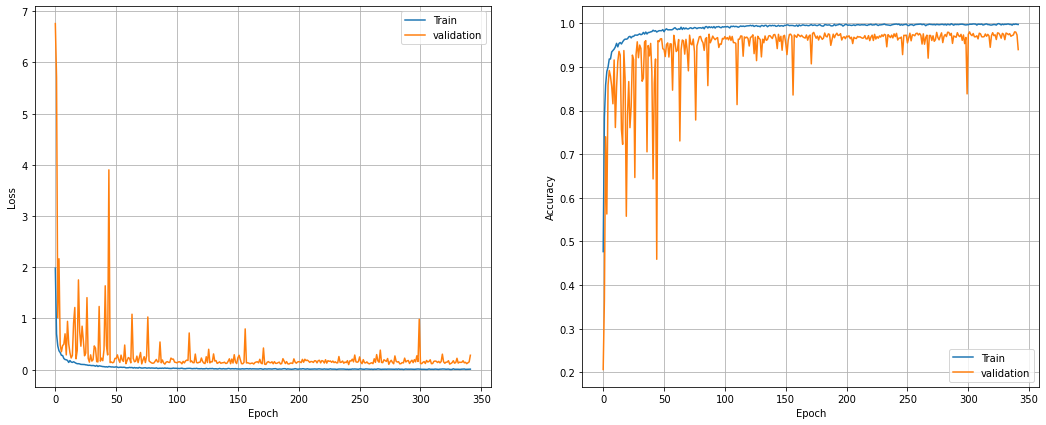

In [61]:
hist = pd.DataFrame(history_06.history)

fig, ax = plt.subplots(1,2, figsize=(18,7))
ax[0].plot(hist.loss, label='Train' )
ax[0].plot(hist.val_loss, label='validation' )
ax[0].legend()
ax[0].grid()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')


ax[1].plot(hist.accuracy, label='Train' )
ax[1].plot(hist.val_accuracy, label='validation' )
ax[1].legend()
ax[1].grid()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
plt.show()


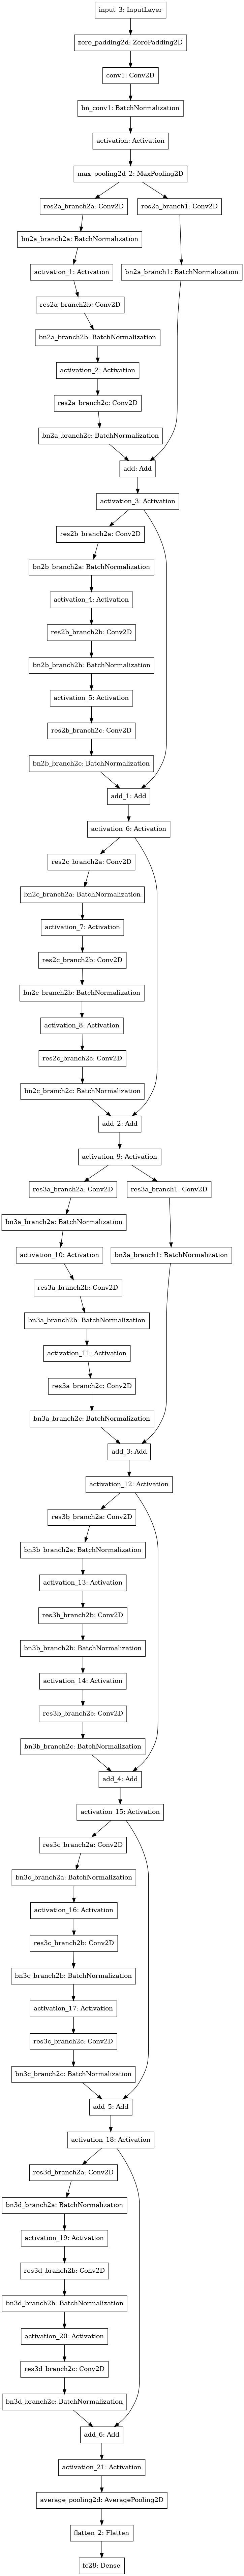

In [62]:
keras.utils.plot_model(model_06)

## Heatmap

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


<AxesSubplot:>

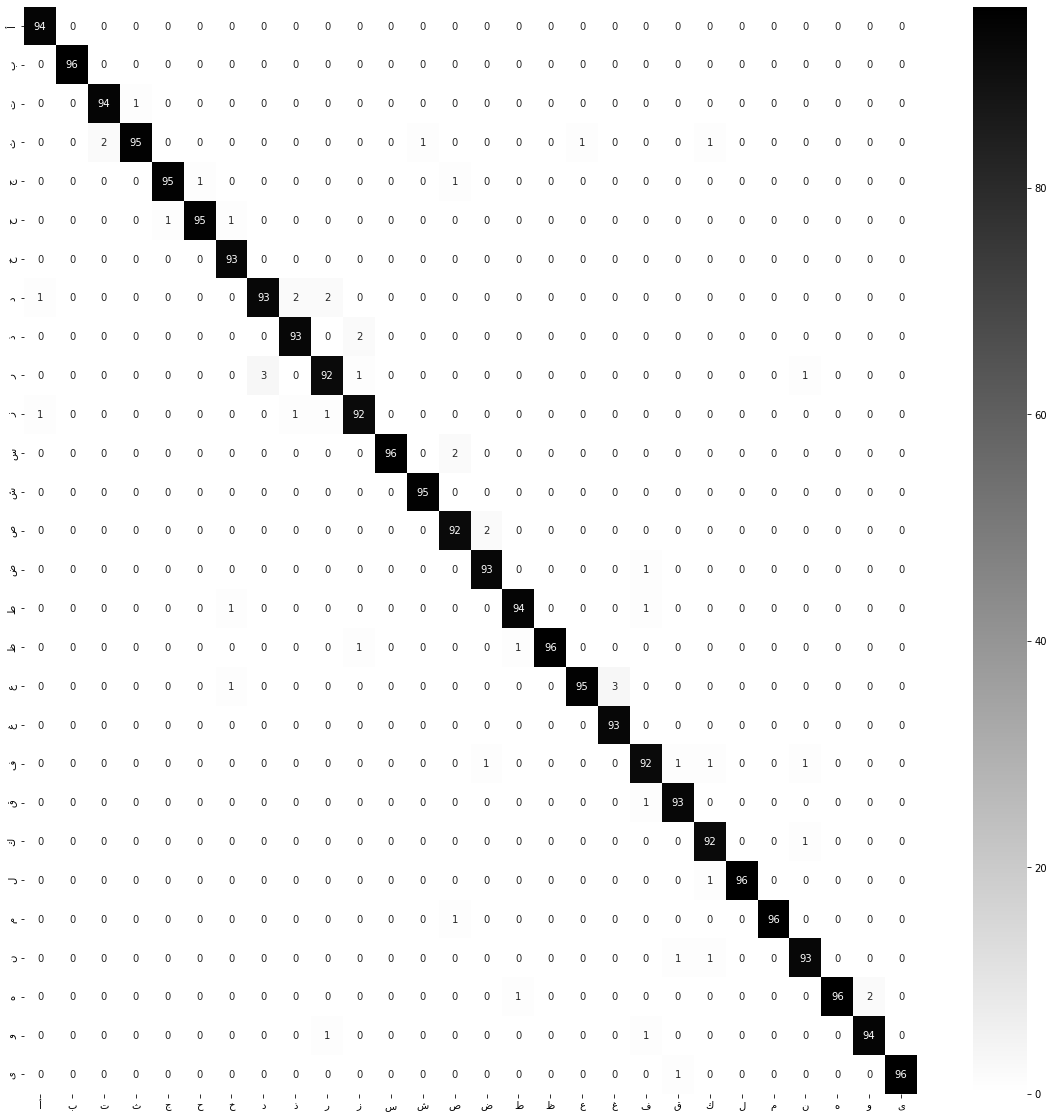

In [63]:
y_true_val  =  np.array([np.argmax(val_gen[i][1], axis=1) for i in range(len(val_gen))]).reshape(val_gen.classes.shape)   
# not sure this line is correct
y_preds_val =  model_01.predict(val_gen).argmax(axis=1)
cm = confusion_matrix(y_true_val, y_preds_val).T

plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True,
#             fmt="d",
            cmap="binary",
            xticklabels=arabic_characters,
            yticklabels=arabic_characters,
           )


---
# Prediction - Ensembling MODELS
---

### All Models

In [64]:
all_models   = [ 
    model_01, 
    model_02, 
#     model_03, 
#     model_04, 
    model_06 
]
# merged_model = model_05

In [65]:
# make predictions
yhats = [ model.predict(test_ds) for model in all_models ]
# medged_pred = model_05.predict(get_predict_data(test_ds))
# yhats.append(medged_pred)

yhats = np.array(yhats)

# sum across ensembles
summed = np.sum(yhats, axis=0)

# argmax across classes
outcomes = np.argmax(summed, axis=1) + 1

In [66]:
yhats.shape

(3, 3360, 28)

In [67]:
# argmax across classes

CNN_outcome      = np.argmax(yhats[0], axis=1) + 1
VGG16_outcome    = np.argmax(yhats[1], axis=1) + 1
# MobNet_outcome   = np.argmax(yhats[2], axis=1) + 1
# Xception_outcome = np.argmax(yhats[3], axis=1) + 1
RNN_outcome      = np.argmax(yhats[2], axis=1) + 1
# MERGED_outcome   = np.argmax(yhats[5], axis=1) + 1

In [68]:
test_df_pred = pd.DataFrame( {
        'id'                  :  file_names,
        'ENSEMBLED'           :  outcomes ,
        'CNN'                 :  CNN_outcome      ,
        'VGG16'               :  VGG16_outcome    ,
#         'MobNet'              :  MobNet_outcome   ,
#         'Xception'            :  Xception_outcome ,
        'RNN'                 :  RNN_outcome      ,
#         'MERGED'              :  MERGED_outcome   ,

        'Ensemble_Letter'     :  arabic_characters[outcomes -1] ,
        'CNN_Letter'          :  arabic_characters[CNN_outcome -1]      ,
        'VGG16_Letter'        :  arabic_characters[VGG16_outcome -1]    ,
#         'MobNet_Letter'       :  arabic_characters[MobNet_outcome -1]   ,
#         'Xception_Letter'     :  arabic_characters[Xception_outcome -1] ,
        'RNN_Letter'          :  arabic_characters[RNN_outcome -1]      ,
#         'MERGED_Letter'       :  arabic_characters[MERGED_outcome -1]
})

test_df_pred

,id,ENSEMBLED,CNN,VGG16,RNN,Ensemble_Letter,CNN_Letter,VGG16_Letter,RNN_Letter
0,0,26,26,26,26,ه,ه,ه,ه
1,1,10,10,10,10,ر,ر,ر,ر
2,2,1,1,1,1,أ,أ,أ,أ
3,3,10,10,10,10,ر,ر,ر,ر
4,4,15,15,15,15,ض,ض,ض,ض
...,...,...,...,...,...,...,...,...,...
3355,3355,16,16,16,16,ط,ط,ط,ط
3356,3356,6,6,6,6,ح,ح,ح,ح
3357,3357,4,4,4,4,ث,ث,ث,ث
3358,3358,11,11,11,11,ز,ز,ز,ز


In [69]:
test_df_pred.to_csv('test_df_pred_all_models.csv', index=False)

In [70]:
test_df = pd.DataFrame( { 'id' : file_names, 
                         'label':outcomes, 
                         'letter':arabic_characters[outcomes-1]} )
test_df

,id,label,letter
0,0,26,ه
1,1,10,ر
2,2,1,أ
3,3,10,ر
4,4,15,ض
...,...,...,...
3355,3355,16,ط
3356,3356,6,ح
3357,3357,4,ث
3358,3358,11,ز


---
# Submission
---

In [71]:
test_df[['id','label']].to_csv('submission.csv', index=False)